This notebook is part of the youtube video "Jet Engine Series" from the Flight Test Engineering Channel: follow this [link](https://youtube.com/@flighttestengineering)

Episode 1: Series Intro

Episdoe 2: Inlet Thermodynamics

Episode 3: Inlet Python Coding

Episode 4: Compressor Thermodynamics

Episode 5: Compressor Python Coding

Episode 6: Combustor Thermo + Python Coding

Episode 7: Turbine Thermo + Python Coding

Episode 8: Nozzle Thermo + Python Coding

Episode 9: Mass flow Python Coding

Episode 10: *Combustor Limit Temperature Python Coding* - use this notebook

In [1]:
#01 - preamble, imports

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import cantera as ct
import ISA_module as ISA

from engine_helper_functions import *

plt.rcParams['figure.figsize'] = [12, 7]

In [2]:
ct.__version__

'3.0.0'

In [3]:
#02 - engine parameters definitions

eng_param = {} # engine physical parameters will be stored in this dictionary

eng_perf = {} # engine performance parameters in this dictionary

# engine parameters
# inlet
#   physical parameters
eng_param['A1'] = 0.30 # m2 inlet area at station 1
eng_param['A2'] = 0.32 # m2 inlet exit area at face of compressor
#   performance parameters
eng_perf['eta_i'] = 0.98 # this can be upgraded to vary with Mach and m_dot

#--------------------------------------------------------------------------

# compressor
#   physical parameters
eng_param['comp_n_stages'] = 10 # number of stages in compressor
#   performance parameters
eng_perf['CPR'] = 6.1  # overall compressor pressure rise
eng_perf['eta_c'] = 0.80 # isentropic stage efficiency for compressor

#--------------------------------------------------------------------------

# combustor
#   physical parameters
#none
#   performance parameters
eng_perf['eta_b'] = 0.9 #combustion efficiency
eng_perf['dp_over_p'] = 0.06 # loss of total pressure in combustor, in percent of inlet pressure
eng_perf['max_f'] = 0.25 # maximum fuel - percent of stoichiometric - allowed in burner - burner swirl/hot limited
eng_perf['min_f'] = 0.125 # minimum fuel - % of stoich - allowed in burner - flame stability limited
eng_perf['V_nominal'] = 45 # [m/s] - nominal combustor flow velocity
eng_perf['T_max'] = 1200 # [K] maximum combustion chamber temperature

#--------------------------------------------------------------------------

# turbine
#   physical parameters
eng_param['turb_n_stages'] = 2 # number of stages in turbine
#   performance parameters
eng_perf['eta_t'] = 0.80 # isentropic stage efficiency for turbine
eng_perf['mech_loss'] = 0.99 # mechanical loss on drivetrain from turbine to compressor

#---------------------------------------------------------------------------

# nozzle
#   physical parameters
eng_param['A8'] = 0.27 # nozzle area in m2
#   performance parameters
eng_perf['eta_noz'] = 0.8 # nozzle losses due to friction

In [4]:
#03 - inlet iterative function

def iterate_inlet(mdot:float, 
                  A:float, 
                  gas_in:ct.Solution, 
                  eta_i:float, 
                  M_in:float, 
                  gas_out:ct.Solution)->(float, bool):
    '''
    This function iterates the gas velocity at inlet exit until convergence
    
    inputs
    mdot : mass flow, in kg/s
    A     : area, in m2
    gas_in: Cantera solution object with gas at entrance of inlet
    T_in  : stagnation temperature of gas at entrance of inlet, in K
    p_in  : stagnation pressure of gas at entrance of inlet, in Pascals
    eta_i : inlet efficiency
    M_in  : Mach number for gas at entrance of inlet
    gas_out: Cantera solution object with gas at exit of inlet
    
    returns
    M_out : Mach number for gas at exit of inlet. Zero if no convergence reached
    convergence: True if converged, False if not
    indirect outputs
    gas_out: Cantera solution containing updated gas properties
    '''
    # loop control
    tol = 0.01 # tolerance to check for convergence
    max_iter = 100 # maximum number of iterations
    converged = False # keeps track of convergence
    n_iter = 0 #iteration counter
    
    # calculated input gas properties
    V_in = M_in * get_a(gas_in)
    gamma_in = get_gamma(gas_in)
    T_0in = get_T(gas_in.T, gamma_in, M_in)
    p_0in = get_p(gas_in.P, gamma_in, M_in)

    # initial guess
    T_0out = T_0in
    V_out_guess = mdot / (gas_in.density * A)
    gamma_out = gamma_in
    
    
    while not converged and n_iter <= max_iter:
        
        # calc properties using current guess
        
        T_out = gas_in.T + (V_in**2 / (2 * gas_in.cp) - V_out_guess**2 / (2 * gas_out.cp))
        p_0out = gas_in.P * (1 + eta_i * V_in**2 / (2 * gas_in.cp * gas_in.T))**(gamma_in / (gamma_in - 1))
        p_out = p_0out * (T_out / T_0out)**(gamma_out / (gamma_out - 1))
              
        # update gas to get new properties (especially density)
        gas_out.TP = T_out, p_out
        gamma_out = get_gamma(gas_out)
        
        # update velocity calculation with new gas properties
        V_out = V_out_guess
        V_out_guess = mdot / (gas_out.density * A)
        
        # check for convergnece
        if abs(V_out - V_out_guess) < tol:
            # print(f'inlet finished, converged, niter={n_iter}')
            converged = True
            M_out = V_out / get_a(gas_out)
        elif n_iter < max_iter:
            n_iter += 1
        else:
            M_out = 0
            print(f'inlet finished, NOT converged, niter={n_iter}')
            
    return M_out, converged            

In [5]:
#08 - multi-stage compressor - "constant" temp rise

def multi_stage_compressor(gas_in:ct.Solution, 
                          n_stages:float, 
                          CPR:float, 
                          eta_c:float, 
                          M_in:float,
                          gas_out:ct.Solution):
    '''
    This function calculates the output properties of a multi-stage axial compressor
    
    inputs
    gas_in    : Cantera solution object with gas at entrance of inlet
    n_stages  : number of stages in axial compressor
    CPR       : overall compression ratio
    eta_c     : stage isentropic efficiency
    M_in      : Mach number for gas at entrance of inlet
    gas_out   : Cantera solution object with gas at exit of inlet
    
    returns
    T_out, p_out : list with static temperatures, static pressures of each stage
    convergence  : True if converged, False if not
    compressor_work : specific work used to compress gas [in kJ/kg]
    
    indirect outputs
    gas_out: Cantera solution containing updated gas properties
    '''
    
    # calculated input gas properties
    gamma_in = get_gamma(gas_in)
    T_0in = get_T(gas_in.T, gamma_in, M_in) # stagnation
    p_0in = get_p(gas_in.P, gamma_in, M_in) # stagnation
    
    # pressure ratio per stage
    CR_stage = CPR**(1 / n_stages)
    
    
    # gradually shift pressure towards the initial stages
    stage_multiplier = np.ones(n_stages)
    shift = 0.001 # overall shift amount, per iteration
    shifter = np.ones(n_stages)
    step_shift = shift / n_stages # shift step per stage
    
    center = int(n_stages / 2) # middle of vector - it does not matter if we are off by one (even length vector)
    for i in range(center):
        shifter[i] = 1 + (center - i) * step_shift # shift initial stages UP
        shifter[n_stages - i - 1] = 1 - ((center - i) * step_shift) # shift later stages DOWN
    
    # pressure rise shift loop control
    converged = False
    n_iter = 0
    max_iter = 5000
    prev_delta_t = 1000 # start with high value to trigger condition
    
    # stage properties
    stages_p_out = np.zeros(n_stages) # holds the press data for each stage
    stages_T_out = np.zeros(n_stages) # holds the temp data for each stage
    stage_gas = (ct.Solution(reaction_mechanism, phase_name)) # internal object to keep track of gas properties
    stage_gas.X = comp_air
    
    # compressor output data
    compressor_work = 0 # collector for specific work used to compress gas, for all stages, in kJ/kg

    
    # pressure rise shift loop
    while not converged and n_iter <= max_iter:

        stage_gas.TP = gas_in.T, gas_in.P
        
        # thermo stages loop
        for st_counter in range(n_stages):

            T_i = stage_gas.T # keep initial temperature for work calculation
            
            gamma = get_gamma(stage_gas)
            p0 = get_p(stage_gas.P, gamma, M_in) * CR_stage * stage_multiplier[st_counter]
            T0 = T_0in / eta_c *((p0 / p_0in)**((gamma - 1) / gamma) - 1) + T_0in

            T = get_Ts(T0, gamma, M_in)
            p = get_ps(p0, T, T0, gamma)
            stage_gas.TP = T, p # do an update on TP, with previous gamma

            gamma = get_gamma(stage_gas) # update gamma
            T = get_Ts(T0, gamma, M_in)
            p = get_ps(p0, T, T0, gamma)
            stage_gas.TP = T, p # refine TP with updated gamma
            
            # store conditions for plotting later...
            stages_p_out[st_counter] = p
            stages_T_out[st_counter] = T
            
            # store stage work
            compressor_work += stage_gas.cp * (T - T_i) # in kJ/kg

            # update for next stage
            p_0in = p0
            T_0in = T0

        # logic to account for different number of stages
        if n_stages > 2: # typical multi-stage case
            max_delta_t = np.diff(stages_T_out).max()
        elif n_stages > 1: # special case : np.diff will drop one in vector length
            max_delta_t = max(stages_T_out[1] - stages_T_out[0], stages_T_out[0] - gas_in.T)
        else: # case for 1 stage
            max_delta_t = T - gas_in.T
        

        # loop objective is to get minimum temperature difference between all stages
        # by shifting pressure rise towards initial stages
        if max_delta_t < prev_delta_t and n_iter < max_iter:

            n_iter += 1
            # clear previous data and reset inputs
            T_0in = get_T(gas_in.T, gamma_in, M_in)
            p_0in = get_p(gas_in.P, gamma_in, M_in)
            compressor_work = 0 #zero out work absorbed by compressor
            
            # increase pressure shift towards initial stages
            stage_multiplier = np.multiply(stage_multiplier, shifter)
            prev_delta_t = max_delta_t
        
        elif n_iter >= max_iter:
            print(f'compressor finished, NOT converged, niter={n_iter}, max delta T={max_delta_t:0.1f}')
            n_iter += 1
        else:
            converged = True
            # print(f'compressor finished, converged, niter={n_iter}, max delta T={max_delta_t:0.1f}')
        
        
    # update gas_out to pass properties back
    gas_out.TP = T, p

    return list(zip(stages_T_out, stages_p_out)), converged, compressor_work

In [6]:
#11 - combustor

# first, set fuel mixture according to a percentage of the stoichiometric
phi = (eng_perf['max_f'] - eng_perf['min_f']) * eng_op_con['throttle_pos'] + eng_perf['min_f'] # 
gas[st[4]].set_equivalence_ratio(phi=phi, fuel=comp_fuel, oxidizer=comp_air, basis='mole') #phi=1 means stoichchiometric air-fuel ratio

# then, get the mass fraction from the mixture before we burn it
mixt_frac = gas[st[4]].mixture_fraction(fuel=comp_fuel, oxidizer=comp_air, basis='mass') #(kg fuel / (kg fuel + kg oxidizer))

# iterate combustor with "cold" fuel-air mixture
M_calc, conv = iterate_combustor(gas[st[3]], 
                                 eng_perf['V_nominal'], 
                                 M[3], 
                                 eng_perf['dp_over_p'], 
                                 gas[st[4]])
if conv: 
    M[st[4]] = M_calc
else:
    print('ERROR: combustor did not converge')
    ###break

# burn, baby burn!
gas[st[4]].equilibrate('HP')

st_T.append(gas[st[4]].T)
st_p.append(gas[st[4]].P)
st_X.append(gas[st[4]].X)


# propagate combustion gas composition downstream
for i in st[5:]:
    gas[i].TPX = st_T[-1], st_p[-1], st_X[-1]


In [7]:
#12 - multi-stage turbine

def multi_stage_turbine(gas_in:ct.Solution, 
                          W_c:float,
                          n_stages:float,  
                          eta_t:float, 
                          eta_m:float,
                          M_in:float,
                          M_out:float,
                          gas_out:ct.Solution):
    '''
    This function calculates the output properties of a multi-stage axial turbine
    
    inputs
    gas_in    : Cantera solution object with gas at entrance of inlet
    W_c       : specific work consumed by compressor [in kJ/kg]
    n_stages  : number of stages in axial compressor
    eta_t     : stage isentropic efficiency
    eta_m     : mechanical efficiency in power transmission from turbine to compressor
    M_in      : Mach number for gas at entrance of inlet
    M_out     : design Mach number for turbine stages
    gas_out   : Cantera solution object with gas at exit of inlet
    
    returns
    T_out, p_out : list with static temperatures, static pressures of each stage
    turbine_work : specific work obtained from turbine [in kJ/kg]
    
    indirect outputs
    gas_out: Cantera solution containing updated gas properties
    '''
    
    # calculated input gas properties
    gamma_in = get_gamma(gas_in)
    T_0in = get_T(gas_in.T, gamma_in, M_in)
    p_0in = get_p(gas_in.P, gamma_in, M_in)
    

    # update properties for exit Mach number    
    T_in = get_Ts(T_0in, gamma_in, M_out)
    p_in = get_ps(p_0in, T_in, T_0in, gamma_in)
    
    
    # specific work per stage
    W_per_stage = (W_c / eta_m) / n_stages
    
    # stage properties
    stages_p_out = np.zeros(n_stages) # holds the press data for each stage
    stages_T_out = np.zeros(n_stages) # holds the temp data for each stage
    stage_gas = (ct.Solution(reaction_mechanism, phase_name)) # internal object (to function) to keep track of gas properties
    stage_gas.TPX = T_in, p_in, gas_in.X
    
    # turbine output data
    turbine_work = 0 # specific work obtained from gas expansion, sum for all stages, in kJ/kg


    # thermo stages loop
    for st_counter in range(n_stages):

        gamma = get_gamma(stage_gas)
        T_i = stage_gas.T # keep intiial temperature to calculate work later
        T_0out_prime = T_0in - (W_per_stage) / (stage_gas.cp * eta_t)
        p_0out = p_0in * (T_0out_prime / T_0in)**(gamma / (gamma - 1))
        T_0out = T_0in - eta_t * (T_0in - T_0out_prime)

        # get static properties
        T = get_Ts(T_0out, gamma, M_out)
        p = get_ps(p_0out, T, T_0out, gamma)
        stage_gas.TP = T, p # do an update on TP, with current gamma

        gamma = get_gamma(stage_gas) # update gamma
        T = get_Ts(T_0out, gamma, M_out)
        p = get_ps(p_0out, T, T_0out, gamma)
        stage_gas.TP = T, p # refine TP with updated gamma

        # store conditions for plotting later...
        stages_p_out[st_counter] = p
        stages_T_out[st_counter] = T
        
        # store stage work        
        turbine_work += stage_gas.cp * (T - T_i) # in kJ/kg

        # update for next stage
        p_0in = p_0out
        T_0in = T_0out


    # update gas_out to pass properties back
    gas_out.TP = T, p

            
    return list(zip(stages_T_out, stages_p_out)), turbine_work

In [8]:
#14 - nozzle

def calc_nozzle(gas_in:ct.Solution,
                M_in:float,
                eta_noz:float, 
                p_amb:float,
                A_star:float,
                V_i:float,
                gas_out:ct.Solution):
    '''
    This function calculates the flow though a convergent nozzle
    
    inputs
    gas_in: Cantera solution object with gas at entrance of inlet
    M_in : Mach nunmer at inlet of nozzle
    eta_noz : nozzle adiabatic efficiency
    p_amb  : ambient pressure at nozzle exit, in Pascals
    A_star : nozzle exit area, in m2
    V_i  : AIRCRAFT speed = gas speed at engine entrance (inlet), in m/s 
    gas_out: Cantera solution object with gas at exit of inlet
    
    returns
    chocked : True if flow is chocked at nozzle throat
    mdot : mass flow in kg/s
    M_out : Mach number for gas at exit of inlet. Zero if no convergence reached
    F : engine specif thrust. In N*s/kg

    indirect outputs
    gas_out: Cantera solution containing updated gas properties
    '''

    # entry conditions
    gamma = get_gamma(gas_in)
    R = get_R(gas_in)
    p0_in = get_p(gas_in.P, gamma, M_in)
    T0_in = get_T(gas_in.T, gamma, M_in)


    # critical condition for sonic flow at throat
    pc_ratio = 1 / (1 - (1 / eta_noz) * ((gamma - 1)/(gamma + 1)))**(gamma / (gamma - 1))

    # chocked or not?
    if p_amb <= p0_in / pc_ratio:
        chocked = True
        p = p0_in / pc_ratio # critical pressure
        T = T0_in / ((gamma + 1) / 2) # critical temperature
        V = np.sqrt(gamma * R * T) # Mach 1
        rho = p / (R * T)
        mdot = rho * V * A_star # kg/s
        F = (V - V_i) + (A_star / mdot)  * (p - p_amb) # specific thrust [N s / kg]
        M_out = 1
    else:
        chocked = False
        p = p_amb
        T = T0_in - eta_noz * T0_in * (1 - (1 / (p0_in / p_amb)**((gamma - 1) / gamma)))
        V = np.sqrt(2 * gas_in.cp * (T0_in - T)) # m/s
        rho = p / (R * T)
        mdot = rho * V * A_star # kg/s
        F = (V - V_i) # specific thrust [N s / kg] Note this is the same as [m/s]
        
    
    gas_out.TP = T, p
    
    if not chocked:
        M_out = V / get_a(gas_out)
    
    return chocked, mdot, M_out, F

In [9]:
def calc_thrust(eng_param:dict, 
                eng_perf:dict, 
                throttle_pos:float=1.0, 
                alt:float=0.0, 
                M_i:float=0.0, 
                mdot_guess=20,
                verbose:bool=False):

    '''
    This function calculates thrust on a turbojet engine
    
    inputs
    eng_param: dictionary containing the following engine data:
        A1 : m2 inlet area at station 1
        A2 : m2 inlet exit area at face of compressor
        compr_n_stages : number of stages in compressor
        turb_n_stages : number of stages in turbine
        A8 : nozzle area in m2
    eng_perf: dictionary containing engine performance parameters:
        eta_i : inlet adiabatic efficiency
        CPR : compressor overall pressure ratio
        eta_c : compressor isentropic efficiency
        eta_b : combustor efficiency
        dp_over_p : loss of total pressure in combustor, in percent of inlet pressure
        max_f : maximum fuel - percent of stoichiometric - allowed in burner - burner swirl/hot limited - typ=0.25
        min_f : minimum fuel - % of stoich - allowed in burner - flame stability limited - typ=0.125
        V_nominal : [m/s] - nominal combustor flow velocity
        eta_t : turbine isentropic efficiency
        mech_loss : mechanical loss from turbine to compressor
        eta_noz : nozzle adiabatic efficiency
    throttle_pos : number between 0.5 (50% throttle) and 1.0 (100%)
    alt : altitude in ft
    M_i : indicated Mach number
    mdot_guess : initial guess for mass flow through engine, in kg/s
    verbose : flag to turn ON/OFF messages and plot

    
    returns a dictionary with the following:
        T : thrust in kN
        mdot_fuel : fuel flow in kg/s
        TSFC : thrust specific fuel consumption in kg / (nK h)
        SAR : specific air range in nm/kg
        mdot_air : air mass flow through engine in kg/s
    '''
    
    
    
    #04 - engine ambient/operating conditions

    eng_op_con = {}
    eng_op_con['throttle_pos'] = throttle_pos # 1 is full throttle; .5 is idle
    eng_op_con['mdot_guess'] = mdot_guess # kg/s
    eng_op_con['alt'] = alt # ft
    eng_op_con['M_i'] = M_i

    V_i = ISA.M2Vt(eng_op_con['M_i'], eng_op_con['alt']) * ISA.kt2ms # true airspeed in kts
    p_amb = ISA.p(eng_op_con['alt']) # static
    T_amb = ISA.T(eng_op_con['alt']) # static

    
    #05 - initial stations setup

    gas = {} # dictionary with Cantera Solution (gas) objects for each station
    M = {} # Mach number for each station

    st = ["a", 1, 2, 3, 4, 5, 8] # station numbers
    station_names = {st[0]:'ambient',
                     st[1]:'inlet',
                     st[2]:'inlet @ comp. face',
                     st[3]:'after compressor',
                     st[4]:'after combustor',
                     st[5]:'after turbine',
                     st[6]:'nozzle exit'}

    # initialize all stations with air, at ambient conditions
    for station in st:
        gas[station] = (ct.Solution(reaction_mechanism, phase_name))
        gas[station].X = comp_air
        gas[station].TP = T_amb, p_amb

        M[station] = M_i
    
    
    
    # mass flow loop convergence control variables
    converged = False
    tol = 0.1 # kg/s
    mdot_iter = 0
    max_mdot_iter = 10
    conv_error = False # keep track of any component convergence error
    
    
    # mass flow loop
    while (not converged) and (mdot_iter <= max_mdot_iter) and (not conv_error):
    
        if verbose: print(f'MDOT ITER#:{mdot_iter}')
        
        #06 - from Station "a" to Station 1

        M_calc, conv = iterate_inlet(eng_op_con['mdot_guess'],
                                     eng_param['A1'],
                                     gas[st[0]],
                                     1, # isentropic thus efficiency=1
                                     M[st[0]],
                                     gas[st[1]])

        # we only assign the Mach number if we reached convergnece
        if conv: M[st[1]] = M_calc
        else: 
            conv_error = True
            print(f'convergence error on station {st[1]}')
            
        # create data set for plotting

        st_T = []
        st_p = []
        st_X = []

        # get T, p, X from each station that we already calculated
        for x in range(0, 2):
            st_T.append(gas[st[x]].T)
            st_p.append(gas[st[x]].P)
            st_X.append(gas[st[x]].X)

        #07 - from Station 1 to Station 2

        M_calc, conv = iterate_inlet(eng_op_con['mdot_guess'] ,
                                     eng_param['A2'],
                                     gas[st[1]],
                                     eng_perf['eta_i'],
                                     M[st[1]],
                                     gas[2])

        # we only assign the Mach number if we reached convergnece
        # and if we did, we now assume constant Mach throughout the machine
        if conv: 
            n_st = len(st) #get number of stations
            current_st = st.index(2) #get index of current station
            for i in range(current_st, n_st):
                M[st[i]] = M_calc
        else:
            conv_error = True
            print(f'convergence error on station {st[2]}')

        st_T.append(gas[st[2]].T)
        st_p.append(gas[st[2]].P)
        st_X.append(gas[st[2]].X)

        #09 - calculate compressor exit station


        st_out, conv, compressor_work = multi_stage_compressor(gas[2], 
                                        eng_param['comp_n_stages'], 
                                        eng_perf['CPR'], 
                                        eng_perf['eta_c'], 
                                        M[st[2]], 
                                        gas[st[3]])


        if not conv: 
            conv_error = True
            print(f'convergence error on station {st[3]}')
            

        # add T, p, X from compressor stages
        for x in st_out:
            st_T.append(x[0])
            st_p.append(x[1])
            st_X.append(st_X[2]) # we just add a fixed value here because the composition in the compressor is not changing


        #11 - combustor
        
        # change log
        # implemented maximum temperature at combustor
        # per SARAVANAMUTTOO: 
        # "development of improved materials and methods of blade cooling
        # ...has enabled permissible combustor outlet temperatures to 
        # rise from about 1100K to as much as 1850K for aircraft applications"

        T_loop = True # flag to control limit temperature loop 
        T_throttle = 1.0 # if T_max is reached, reduce throttle by multiplying by this factor
        T_throttle_limit = 0.5 # maximum reduction of throttle allowed before declaring non-convergence

        while T_loop:
            # first, set fuel mixture according to a percentage of the stoichiometric
            phi = (eng_perf['max_f'] - eng_perf['min_f']) * eng_op_con['throttle_pos'] * T_throttle + eng_perf['min_f'] # 
            gas[st[4]].set_equivalence_ratio(phi=phi, fuel=comp_fuel, oxidizer=comp_air, basis='mole') #phi=1 means stoichchiometric air-fuel ratio

            # then, get the mass fraction from the mixture before we burn it
            mixt_frac = gas[st[4]].mixture_fraction(fuel=comp_fuel, oxidizer=comp_air, basis='mass') #(kg fuel / (kg fuel + kg oxidizer))

            # iterate combustor with "cold" fuel-air mixture
            M_calc, conv = iterate_combustor(gas[st[3]], 
                                             eng_perf['V_nominal'], 
                                             M[3], 
                                             eng_perf['dp_over_p'], 
                                             gas[st[4]])
            if conv: 
                M[st[4]] = M_calc
            else:
                print('ERROR: combustor did not converge')
                ###break

            # burn, baby burn!
            gas[st[4]].equilibrate('HP')

            # check for Temperature exceedance
            if gas[st[4]].T > eng_perf['T_max']:
                T_throttle = T_throttle - 0.001 # reduce throttle by 0.1%
                #print(f'reducing throttle, multiplier = {T_throttle}')
            elif T_throttle < T_throttle_limit:
                print('Combustor temperature not feasible, throttled back to limit')
                T_loop = False # just to get out of loop
            else:
                T_loop = False

        if T_throttle < 1.0:
            print(f' T_max reached, reduced throttle by: {T_throttle:.4f}')
        st_T.append(gas[st[4]].T)
        st_p.append(gas[st[4]].P)
        st_X.append(gas[st[4]].X)

        # propagate combustion gas composition downstream
        for i in st[5:]:
            gas[i].TPX = st_T[-1], st_p[-1], st_X[-1]


        #13 - turbine

        st_out, turbine_work = multi_stage_turbine(gas[st[4]], 
                                  compressor_work,
                                  eng_param['turb_n_stages'],  
                                  eng_perf['eta_t'], 
                                  eng_perf['mech_loss'],
                                  M[st[4]],
                                  M[st[5]],
                                  gas[st[5]])

        # add T, p, X from turbine stages
        for x in st_out:
            st_T.append(x[0])
            st_p.append(x[1])
            st_X.append(gas[st[5]].X) # we just add a fixed value here because the composition in the compressor is not changing


        #15 - nozzle

        chocked, mdot_noz, M[st[6]], F = calc_nozzle(gas[st[5]],
                                           M[st[5]],
                                           eng_perf['eta_noz'], 
                                           p_amb, 
                                           eng_param['A8'],
                                           V_i,
                                           gas[st[6]])

        
        
        # massflow convergence check
        if verbose: 
            print(f"delta mdot = {mdot_noz - eng_op_con['mdot_guess']}")

        if abs(mdot_noz - eng_op_con['mdot_guess']) < tol:
            converged = True
            if verbose:
                print(f"converged!")
                print()
        else:
            mdot_iter += 1
            eng_op_con['mdot_guess'] = mdot_noz
            if verbose: print()

        st_T.append(gas[st[6]].T)
        st_p.append(gas[st[6]].P)
        st_X.append(gas[st[6]].X)



    # SFC calculation
    mdot_fuel = (mixt_frac / eng_perf['eta_b']) * mdot_noz # in [kg/s]
    TSFC = (mdot_fuel / mdot_noz) / F # [kg/(s N)]

    SAR = V_i / mdot_fuel # in [m/kg]
    
    if verbose:
        print(f"Thrust={F*mdot_noz/1000:.0f} kN, Alt = {eng_op_con['alt']:.0f} ft, T_ambient = {T_amb:.1f} K, M_i={M_i}")
        print(f'Mass flow={mdot_noz:.0f} kg/s')
        print(f'Fuel Flow: {mdot_fuel*3600:.0f} kg/h, TSFC: {TSFC*3600*1000:.1f} kg / (kN h)')
        print(f'specific air range = {SAR:.1f} m/kg = {V_i*ISA.ms2kt / (mdot_fuel * 3600):.4f} nm/kg')
        print()
        print_stations(st, station_names, gas, M)
        myplot = plot_T_s(st_T, st_p, st_X, reaction_mechanism, phase_name)
        myplot.show()
        
    return {'T':F*mdot_noz/1000,
            'mdot_fuel':mdot_fuel,
            'TSFC':TSFC*3600*1000, # in kg / (kN h)
            'SAR':SAR*ISA.ms2kt/3600, # in nm/kg
            'mdot_air': mdot_noz}

In [10]:
# Global Variables for Cantera Gas Objects

# see https://github.com/Cantera/cantera/blob/main/data/nDodecane_Reitz.yaml
reaction_mechanism = 'nDodecane_Reitz.yaml'
phase_name = 'nDodecane_IG' # IG = ideal gas, other option is RK = Redlich-Kwong

comp_air = 'O2:0.209, N2:0.787, CO2:0.004' # composition of air
comp_fuel = 'c12h26:1' # composition of fuel

MDOT ITER#:0
delta mdot = 3.9451198938751126

MDOT ITER#:1
delta mdot = 0.4496612931816131

MDOT ITER#:2
delta mdot = 0.0677497489745349
converged!

Thrust=11 kN, Alt = 35000 ft, T_ambient = 218.8 K, M_i=0.8
Mass flow=24 kg/s
Fuel Flow: 1019 kg/h, TSFC: 88.7 kg / (kN h)
specific air range = 838.5 m/kg = 0.4528 nm/kg

station a  (ambient         ): Mach 0.800, p = 0.24 atm, T = 219 K, h = -133991 kJ/kg, s = 6986 kJ/kg, 
station 1  (inlet           ): Mach 0.634, p = 0.27 atm, T = 229 K, h = -124236 kJ/kg, s = 6986 kJ/kg, 
station 2  (inlet @ comp. face): Mach 0.574, p = 0.29 atm, T = 232 K, h = -121065 kJ/kg, s = 6987 kJ/kg, 
station 3  (after compressor): Mach 0.574, p = 1.75 atm, T = 440 K, h = 90211 kJ/kg, s = 7116 kJ/kg, 
station 4  (after combustor ): Mach 0.106, p = 2.03 atm, T = 1110 K, h = 93870 kJ/kg, s = 8174 kJ/kg, 
station 5  (after turbine   ): Mach 0.574, p = 0.66 atm, T = 884 K, h = -173867 kJ/kg, s = 8229 kJ/kg, 
station 8  (nozzle exit     ): Mach 1.000, p = 0.37 atm, T

{'T': 11.484403263943925,
 'mdot_fuel': 0.2829356212679997,
 'TSFC': 88.6914376964334,
 'SAR': 0.45276773052950336,
 'mdot_air': 24.46253093603126}

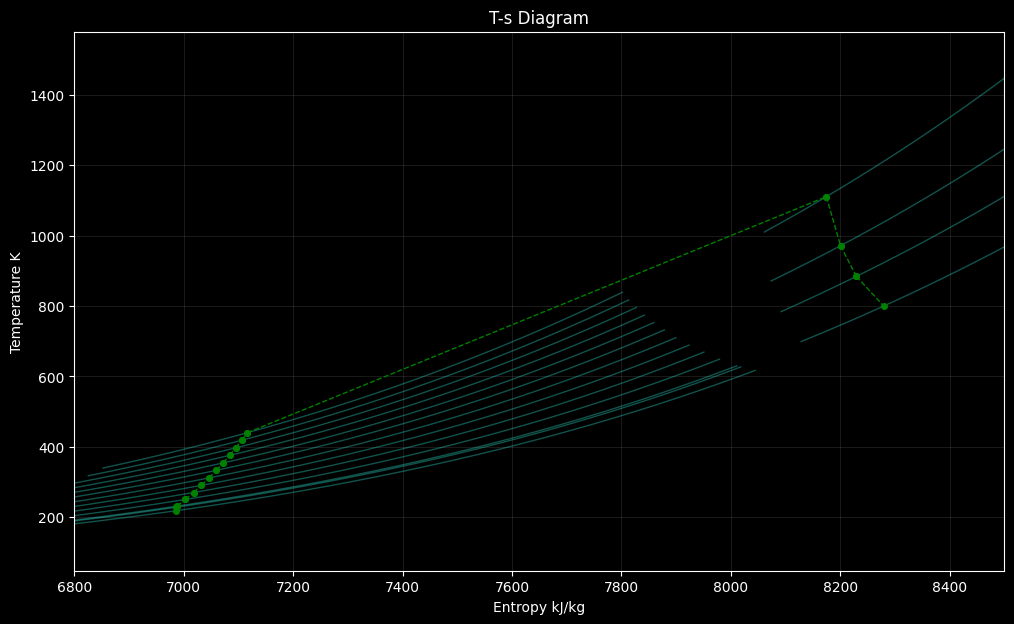

In [11]:
calc_thrust(eng_param, eng_perf, throttle_pos=1.0, alt=35000.0, M_i=0.8, verbose=True)

MDOT ITER#:0
delta mdot = 38.40901036640771

MDOT ITER#:1
delta mdot = 2.116840893103351

MDOT ITER#:2
delta mdot = 0.2425489952110027

MDOT ITER#:3
delta mdot = 0.02947519847790403
converged!

Thrust=33 kN, Alt = 0 ft, T_ambient = 288.1 K, M_i=0.0
Mass flow=61 kg/s
Fuel Flow: 2531 kg/h, TSFC: 77.1 kg / (kN h)
specific air range = 0.0 m/kg = 0.0000 nm/kg

station a  (ambient         ): Mach 0.000, p = 1.00 atm, T = 288 K, h = -64495 kJ/kg, s = 6845 kJ/kg, 
station 1  (inlet           ): Mach 0.598, p = 0.78 atm, T = 269 K, h = -83909 kJ/kg, s = 6845 kJ/kg, 
station 2  (inlet @ comp. face): Mach 0.544, p = 0.81 atm, T = 272 K, h = -80750 kJ/kg, s = 6847 kJ/kg, 
station 3  (after compressor): Mach 0.544, p = 4.97 atm, T = 514 K, h = 166821 kJ/kg, s = 6976 kJ/kg, 
station 4  (after combustor ): Mach 0.098, p = 5.67 atm, T = 1176 K, h = 173636 kJ/kg, s = 7949 kJ/kg, 
station 5  (after turbine   ): Mach 0.544, p = 1.68 atm, T = 924 K, h = -127198 kJ/kg, s = 8011 kJ/kg, 
station 8  (nozzle e

{'T': 32.85067841024451,
 'mdot_fuel': 0.7031931695092377,
 'TSFC': 77.06067371332604,
 'SAR': 0.0,
 'mdot_air': 60.79787545319997}

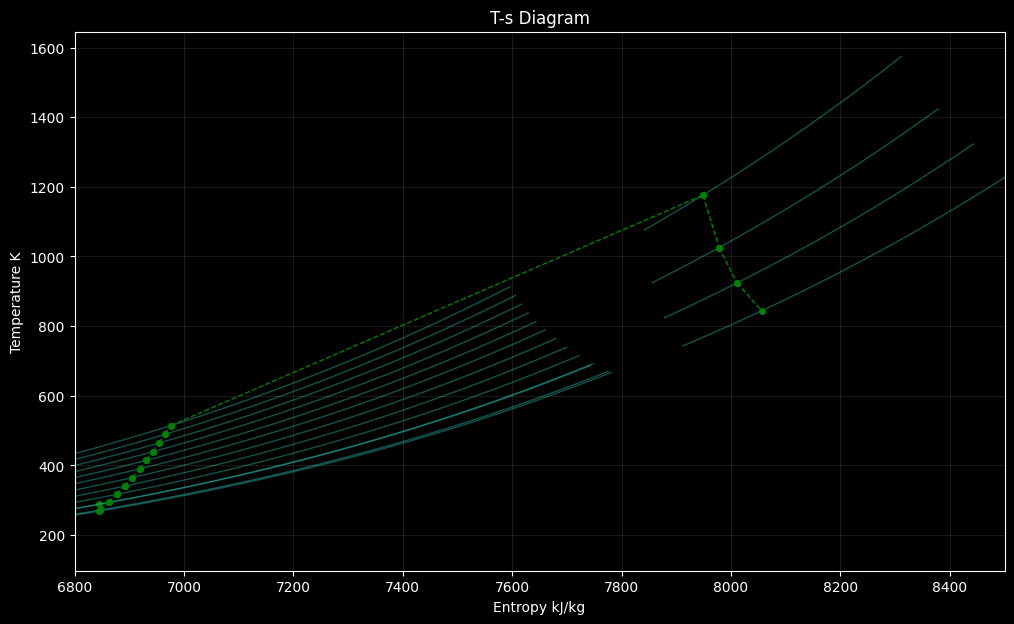

In [12]:
calc_thrust(eng_param, eng_perf, throttle_pos=1.0, alt=0.0, M_i=0.0, verbose=True)

 T_max reached, reduced throttle by: 0.9890
 T_max reached, reduced throttle by: 0.9860
 T_max reached, reduced throttle by: 0.9860
 T_max reached, reduced throttle by: 0.9860
 T_max reached, reduced throttle by: 0.9700
 T_max reached, reduced throttle by: 0.9670
 T_max reached, reduced throttle by: 0.9670
 T_max reached, reduced throttle by: 0.9670
 T_max reached, reduced throttle by: 0.9500
 T_max reached, reduced throttle by: 0.9470
 T_max reached, reduced throttle by: 0.9470
 T_max reached, reduced throttle by: 0.9470
 T_max reached, reduced throttle by: 0.9280
 T_max reached, reduced throttle by: 0.9250
 T_max reached, reduced throttle by: 0.9250
 T_max reached, reduced throttle by: 0.9250
 T_max reached, reduced throttle by: 0.9050
 T_max reached, reduced throttle by: 0.9020
 T_max reached, reduced throttle by: 0.9020
 T_max reached, reduced throttle by: 0.9020
 T_max reached, reduced throttle by: 0.8800
 T_max reached, reduced throttle by: 0.8770
 T_max reached, reduced throttle

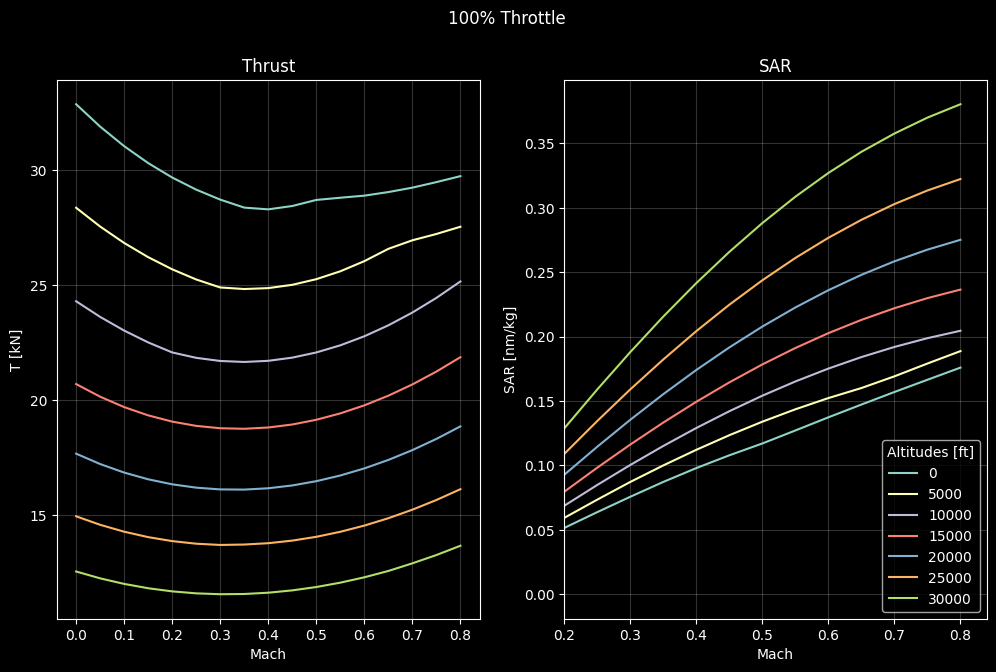

In [13]:
# Thust vs Mach vs Altitude

Machs = np.arange(0.0, 0.805, 0.05)
altitudes = np.arange(0,30001,5000)
throt = 1.0 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'{throt*100:.0f}% Throttle')

for alt in altitudes:
    calculated_thrust = []
    calculated_SAR = []
    for Mach in Machs:
        # print(alt, Mach)
        res = calc_thrust(eng_param, eng_perf, throttle_pos=throt, alt=alt, M_i=Mach, verbose=False)
        calculated_thrust.append(res['T'])
        calculated_SAR.append(res['SAR'])
    ax1.plot(Machs, calculated_thrust)
    ax2.plot(Machs, calculated_SAR, label=f'{alt:.0f}')

ax1.set_title('Thrust')
ax1.set(xlabel='Mach', ylabel='T [kN]')
ax1.grid(alpha=0.2)


ax2.set_title('SAR')
ax2.set(xlabel='Mach', ylabel='SAR [nm/kg]')
ax2.grid(alpha=0.2)
ax2.set_xlim(left=0.2)
ax2.legend(title='Altitudes [ft]', loc='lower right')

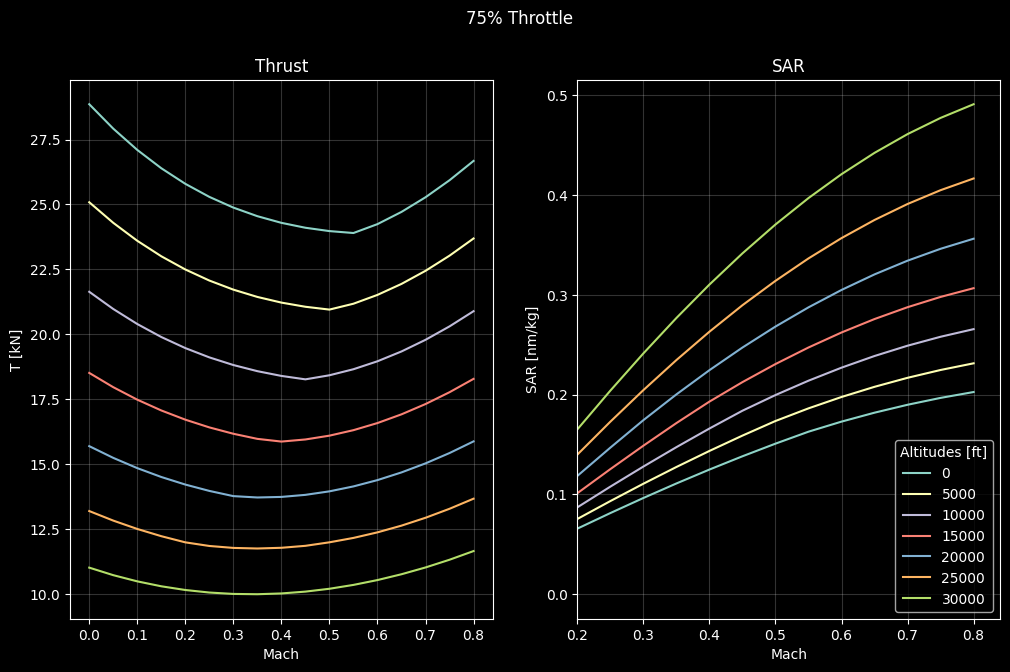

In [14]:
throt = 0.75 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'{throt*100:.0f}% Throttle')

for alt in altitudes:
    calculated_thrust = []
    calculated_SAR = []
    for Mach in Machs:
        # print(alt, Mach)
        res = calc_thrust(eng_param, eng_perf, throttle_pos=throt, alt=alt, M_i=Mach, verbose=False)
        calculated_thrust.append(res['T'])
        calculated_SAR.append(res['SAR'])
    ax1.plot(Machs, calculated_thrust)
    ax2.plot(Machs, calculated_SAR, label=f'{alt:.0f}')

ax1.set_title('Thrust')
ax1.set(xlabel='Mach', ylabel='T [kN]')
ax1.grid(alpha=0.2)


ax2.set_title('SAR')
ax2.set(xlabel='Mach', ylabel='SAR [nm/kg]')
ax2.grid(alpha=0.2)
ax2.set_xlim(left=0.2)
ax2.legend(title='Altitudes [ft]', loc='lower right')

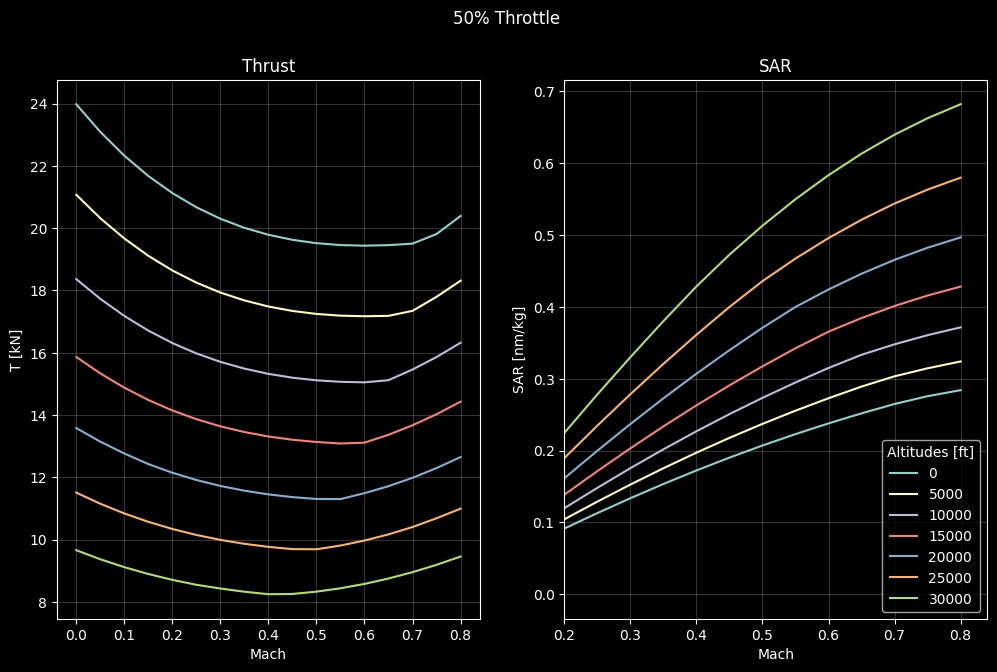

In [15]:
throt = 0.5
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'{throt*100:.0f}% Throttle')

for alt in altitudes:
    calculated_thrust = []
    calculated_SAR = []
    for Mach in Machs:
        # print(alt, Mach)
        res = calc_thrust(eng_param, eng_perf, throttle_pos=throt, alt=alt, M_i=Mach, verbose=False)
        calculated_thrust.append(res['T'])
        calculated_SAR.append(res['SAR'])
    ax1.plot(Machs, calculated_thrust)
    ax2.plot(Machs, calculated_SAR, label=f'{alt:.0f}')

ax1.set_title('Thrust')
ax1.set(xlabel='Mach', ylabel='T [kN]')
ax1.grid(alpha=0.2)


ax2.set_title('SAR')
ax2.set(xlabel='Mach', ylabel='SAR [nm/kg]')
ax2.grid(alpha=0.2)
ax2.set_xlim(left=0.2)
ax2.legend(title='Altitudes [ft]', loc='lower right')

 T_max reached, reduced throttle by: 0.9890
 T_max reached, reduced throttle by: 0.9860
 T_max reached, reduced throttle by: 0.9860
 T_max reached, reduced throttle by: 0.9860
 T_max reached, reduced throttle by: 0.9700
 T_max reached, reduced throttle by: 0.9670
 T_max reached, reduced throttle by: 0.9670
 T_max reached, reduced throttle by: 0.9670
 T_max reached, reduced throttle by: 0.9500
 T_max reached, reduced throttle by: 0.9470
 T_max reached, reduced throttle by: 0.9470
 T_max reached, reduced throttle by: 0.9470
 T_max reached, reduced throttle by: 0.9280
 T_max reached, reduced throttle by: 0.9250
 T_max reached, reduced throttle by: 0.9250
 T_max reached, reduced throttle by: 0.9250
 T_max reached, reduced throttle by: 0.9050
 T_max reached, reduced throttle by: 0.9020
 T_max reached, reduced throttle by: 0.9020
 T_max reached, reduced throttle by: 0.9020
 T_max reached, reduced throttle by: 0.8800
 T_max reached, reduced throttle by: 0.8770
 T_max reached, reduced throttle

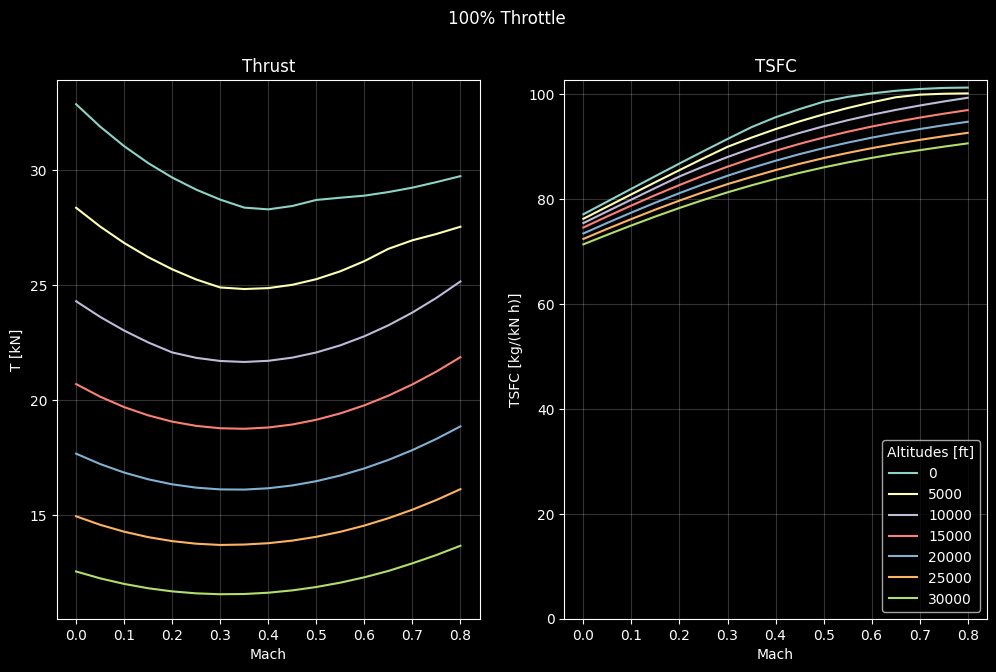

In [16]:
throt = 1.0 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'{throt*100:.0f}% Throttle')

for alt in altitudes:
    calculated_thrust = []
    calculated_TSFC = []
    for Mach in Machs:
        # print(alt, Mach)
        res = calc_thrust(eng_param, eng_perf, throttle_pos=throt, alt=alt, M_i=Mach, verbose=False)
        calculated_thrust.append(res['T'])
        calculated_TSFC.append(res['TSFC'])
    ax1.plot(Machs, calculated_thrust)
    ax2.plot(Machs, calculated_TSFC, label=f'{alt:.0f}')

ax1.set_title('Thrust')
ax1.set(xlabel='Mach', ylabel='T [kN]')
ax1.grid(alpha=0.2)


ax2.set_title('TSFC')
ax2.set(xlabel='Mach', ylabel='TSFC [kg/(kN h)]')
ax2.grid(alpha=0.2)
ax2.set_ylim(bottom=0.0)
ax2.legend(title='Altitudes [ft]', loc='lower right')

In [17]:
# bonus section
# dump engine paramaters to json file
import json


orenda = {'eng_param':eng_param, 'eng_perf':eng_perf}

with open("orenda.json", "w") as outfile: 
    json.dump(orenda, outfile)

In [18]:
# load dictionaries
import json

engine_file = 'orenda.json'


with open(engine_file) as f:
    engine_parameters = json.load(f)

eng_param = engine_parameters['eng_param']
eng_perf = engine_parameters['eng_perf']